<a href="https://colab.research.google.com/github/KatherineYZ/Data-Science-Bootcamp-Fall-2025/blob/main/Homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

path = '/content/drive/MyDrive/Bootcamp/brooklyn_pedestrian_2019.csv'

df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Convert columns to proper types
df['hour_beginning']      = pd.to_datetime(df['hour_beginning'], errors='coerce')
for c in ['Pedestrians', 'Towards Manhattan', 'Towards Brooklyn']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Optional numeric weather fields (if present)
for c in ['temperature', 'precipitation']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Filter to 2019 only
df_2019 = df[df['hour_beginning'].dt.year == 2019].copy()

# Basic sanity check
print("Rows in 2019:", len(df_2019))
df_2019.head()

/tmp/ipython-input-2786420386.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour_beginning']      = pd.to_datetime(df['hour_beginning'], errors='coerce')


Rows in 2019: 8761


,hour_beginning,location,Pedestrians,Towards Manhattan,Towards Brooklyn,weather_summary,temperature,precipitation,lat,long,events,Location1
0,2019-04-30 00:00:00,Brooklyn Bridge,3.0,3.0,0.0,NaN,NaN,NaN,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"
1,2019-12-31 22:00:00,Brooklyn Bridge,10.0,9.0,1.0,cloudy,42.0,0.0005,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"
2,2019-12-31 23:00:00,Brooklyn Bridge,2.0,0.0,2.0,cloudy,42.0,0.0004,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"
3,2019-12-31 21:00:00,Brooklyn Bridge,12.0,0.0,12.0,cloudy,42.0,0.0036,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"
4,2019-04-01 03:00:00,Brooklyn Bridge,1.0,0.0,1.0,clear-night,36.0,0.0000,40.708164,-73.999509,NaN,"(40.7081639691088, -73.9995087014816)"


,avg_pedestrians
DayOfWeek,
Monday,169.386338
Tuesday,161.418322
Wednesday,193.747826
Thursday,173.194323
Friday,144.313539


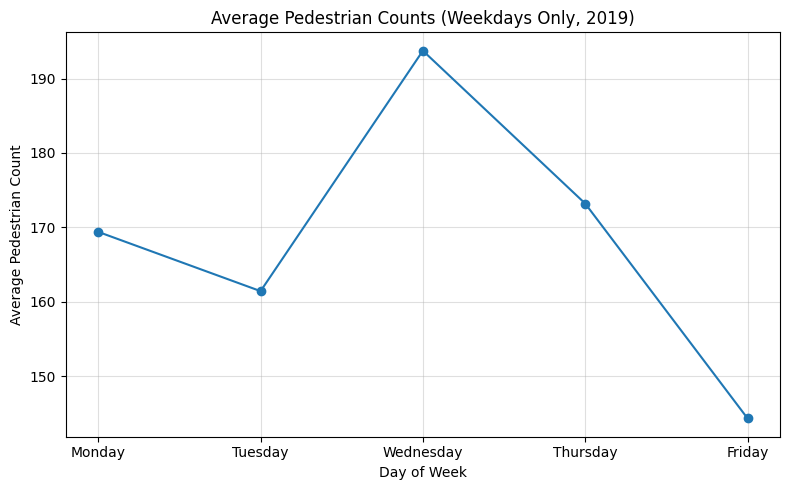

In [9]:
# Day name, weekday list
df_2019['DayOfWeek'] = df_2019['hour_beginning'].dt.day_name()
weekdays_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Keep weekdays only
df_weekdays = df_2019[df_2019['DayOfWeek'].isin(weekdays_order)].copy()

# Average pedestrians per weekday
weekday_counts = (
    df_weekdays.groupby('DayOfWeek')['Pedestrians']
    .mean()
    .reindex(weekdays_order)
)

display(weekday_counts.to_frame('avg_pedestrians'))

# Plot with matplotlib
plt.figure(figsize=(8,5))
plt.plot(weekday_counts.index, weekday_counts.values, marker='o')
plt.title('Average Pedestrian Counts (Weekdays Only, 2019)')
plt.xlabel('Day of Week')
plt.ylabel('Average Pedestrian Count')
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


Average pedestrians by weather_summary (2019):


,avg_pedestrians
weather_summary,
partly-cloudy-day,500.705534
clear-day,462.405607
wind,268.666667
cloudy,186.944203
sleet,178.250000
rain,168.344291
snow,162.638889
fog,120.500000
partly-cloudy-night,49.809287


Correlation matrix:


,Pedestrians,temperature,precipitation
Pedestrians,1.000000,0.062869,-0.021611
temperature,0.062869,1.000000,0.001911
precipitation,-0.021611,0.001911,1.000000


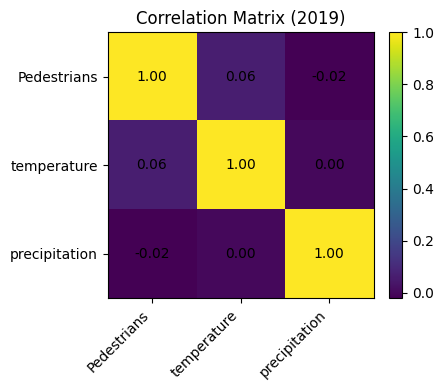

In [10]:
# Mean pedestrians by weather summary (sorted)
if 'weather_summary' in df_2019.columns:
    weather_means = (
        df_2019.groupby('weather_summary')['Pedestrians']
        .mean()
        .sort_values(ascending=False)
    )
    print("Average pedestrians by weather_summary (2019):")
    display(weather_means.to_frame('avg_pedestrians'))
else:
    print("Column 'weather_summary' not found. Skipping weather category means.")
    weather_means = pd.Series(dtype=float)

# Correlation matrix among numeric variables (pedestrians, temperature, precipitation)
numeric_cols = [c for c in ['Pedestrians', 'temperature', 'precipitation'] if c in df_2019.columns]
corr = df_2019[numeric_cols].corr()

print("Correlation matrix:")
display(corr)

# Plot correlation heatmap with matplotlib (no seaborn)
if corr.shape[0] > 0:
    plt.figure(figsize=(5,4))
    im = plt.imshow(corr.values, interpolation='nearest')
    plt.title('Correlation Matrix (2019)')
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha='right')
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    # annotate cells
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            plt.text(j, i, f"{corr.values[i,j]:.2f}", ha='center', va='center')
    plt.tight_layout()
    plt.show()


,avg_pedestrians
TimeOfDay,
Morning,279.212196
Afternoon,617.100592
Evening,206.928654
Night,12.267717


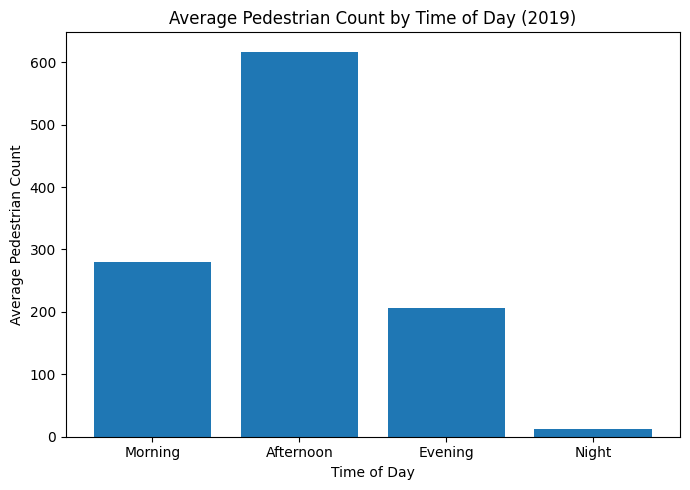

In [11]:
# Extract hour
df_2019['Hour'] = df_2019['hour_beginning'].dt.hour

# Custom time-of-day function
def categorize_time(hour: int) -> str:
    if 5 <= hour < 12:    # 05:00–11:59
        return 'Morning'
    elif 12 <= hour < 17: # 12:00–16:59
        return 'Afternoon'
    elif 17 <= hour < 21: # 17:00–20:59
        return 'Evening'
    else:                 # 21:00–04:59
        return 'Night'

df_2019['TimeOfDay'] = df_2019['Hour'].apply(categorize_time)

# Average pedestrians by TimeOfDay
tod_order = ['Morning', 'Afternoon', 'Evening', 'Night']
tod_means = (
    df_2019.groupby('TimeOfDay')['Pedestrians']
    .mean()
    .reindex(tod_order)
)

display(tod_means.to_frame('avg_pedestrians'))

# Bar chart with matplotlib
plt.figure(figsize=(7,5))
plt.bar(tod_means.index, tod_means.values)
plt.title('Average Pedestrian Count by Time of Day (2019)')
plt.xlabel('Time of Day')
plt.ylabel('Average Pedestrian Count')
plt.tight_layout()
plt.show()
